# Movie Correlation and Regression Analysis
**August 15, 2021**

---

# Import Libraries and Read in the Data

In [1]:
import numpy as np
import pandas as pd

# for data viz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

# for the regression analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data = os.path.join(dirname, filename)

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# filtering warnings
import warnings
warnings.filterwarnings('ignore')

# set to display all rows
pd.set_option('display.max_rows', None)

# size configuration of the plots
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
df = pd.read_csv(data)
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


# Data Cleaning and Transformations

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


##### Handling nulls values (an aesthetically pleasing approach)
I found this slightly more presentable than the common .isna().sum(), even though it's a bit more verbose.

In [5]:
# checking what percentage of the dataset is represented by nulls

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, pct_missing))

name - 0.0%
rating - 0.010041731872717789%
genre - 0.0%
year - 0.0%
released - 0.0002608242044861763%
score - 0.0003912363067292645%
votes - 0.0003912363067292645%
director - 0.0%
writer - 0.0003912363067292645%
star - 0.00013041210224308815%
country - 0.0003912363067292645%
budget - 0.2831246739697444%
gross - 0.02464788732394366%
company - 0.002217005738132499%
runtime - 0.0005216484089723526%


In [6]:
# drop NAs, considering that they represent a very small percentage of our dataset

df.dropna(inplace=True)

##### Dealing with duplicates
In this particular case, the most reasonable approach to check for duplicates would be through the `name` column (since duplicates would be expected for the rest of the columns). Nevertheless, after little investigation, we can see that the duplicates in this column are actually either **remakes** or simply **homonyms**. 
Therefore, *we will not exclude any*.

In [7]:
# a piece of the dataframe, to illustrate:

df[df.name.duplicated(keep=False)].sort_values(by='name',ascending=True).head(10)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5712,A Nightmare on Elm Street,R,Crime,2010,"April 30, 2010 (United States)",5.2,95000.0,Samuel Bayer,Wesley Strick,Jackie Earle Haley,United States,35000000.0,1.156952e+08,New Line Cinema,95.0
483,A Nightmare on Elm Street,R,Horror,1984,"November 16, 1984 (United States)",7.5,212000.0,Wes Craven,Wes Craven,Heather Langenkamp,United States,1800000.0,2.550714e+07,New Line Cinema,91.0
7481,Aladdin,PG,Adventure,2019,"May 24, 2019 (United States)",6.9,239000.0,Guy Ritchie,John August,Will Smith,United Kingdom,183000000.0,1.050694e+09,Walt Disney Pictures,128.0
2056,Aladdin,G,Animation,1992,"November 25, 1992 (United States)",8.0,382000.0,Ron Clements,Ron Clements,Scott Weinger,United States,28000000.0,5.040502e+08,Walt Disney Pictures,90.0
3196,Anna Karenina,PG-13,Drama,1997,"April 4, 1997 (United States)",6.3,5600.0,Bernard Rose,Lev Tolstoy,Sophie Marceau,United States,35000000.0,8.585530e+05,Icon Entertainment International,108.0
6099,Anna Karenina,R,Drama,2012,"September 7, 2012 (United Kingdom)",6.6,95000.0,Joe Wright,Tom Stoppard,Keira Knightley,United Kingdom,40600000.0,6.892915e+07,Universal Pictures,129.0
6471,Annie,PG,Comedy,2014,"December 19, 2014 (United States)",5.3,35000.0,Will Gluck,Will Gluck,Quvenzhané Wallis,United States,65000000.0,1.368535e+08,Marcy Media,118.0
213,Annie,PG,Comedy,1982,"June 18, 1982 (United States)",6.6,41000.0,John Huston,Carol Sobieski,Aileen Quinn,United States,50000000.0,5.706386e+07,Columbia Pictures,127.0
2815,Bad Company,R,Crime,1995,"January 20, 1995 (United States)",5.4,2800.0,Damian Harris,Ross Thomas,Ellen Barkin,United States,15000000.0,3.674841e+06,Touchstone Pictures,108.0
4191,Bad Company,PG-13,Action,2002,"June 7, 2002 (United States)",5.6,45000.0,Joel Schumacher,Gary M. Goodman,Anthony Hopkins,United States,70000000.0,6.620078e+07,Touchstone Pictures,116.0


##### A brief description of what the following transformations aim to do:
* adjust the data types of `budget`, `gross` and `votes` to integer
* split the `released` column into `released_date` and `released_country`. Then change the `released_date` data type to a time series.
* drop the `released` column. Insert the `released_date` year as the `year` column.
* renamed the 'not rated' values in the `rating` column to simply 'unranked' (which is also a label), to reduce redundancy


In [8]:
# adjusting data types and transforming columns

df.budget = df.budget.astype(int)
df.gross = df.gross.astype(int)
df.votes = df.votes.astype(int)

df['released_date'] = df.released.str.split('(', expand=True)[0]
df['released_date'] = pd.to_datetime(df.released_date)
df['year'] = df.released_date.dt.year
df['released_country'] = df.released.str.split('(', expand=True)[1].str.replace(r'[^a-zA-Z\d\s:]', '')
df = df.drop('released', axis=1)

df['rating'] = df.rating.str.replace('Not Rated', 'Unrated')

# EDA
##### Before moving further into the actual analysis, let's explore the dataset through some visualizations.
* 1. What are the top 5 movies by gross revenue? 
* 2. What are the stars that made the most movies in this period of time? And the directors? 
* 3. What are the directors that have generated the most revenue? 
* 4. What is the volume of movies coming out per year?
* 5. What are the best movies by score? 

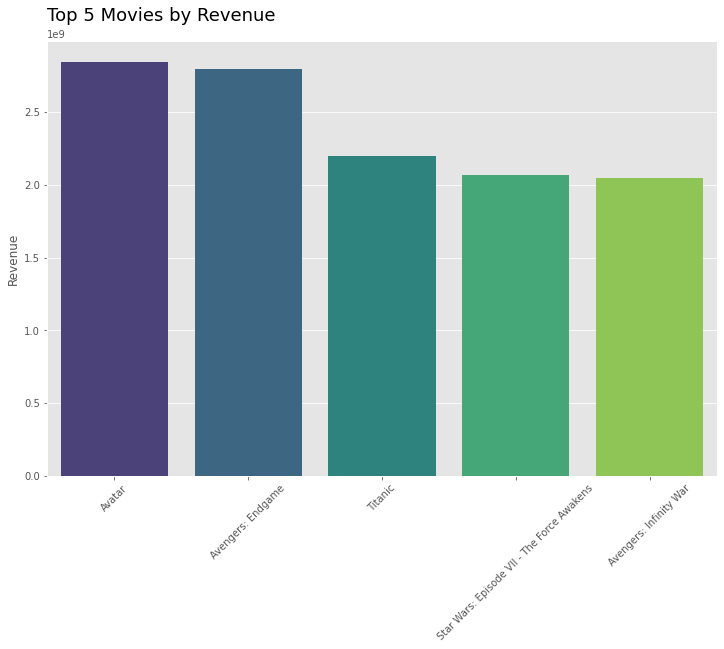

In [9]:
#1 

top5 = df.sort_values(by='gross', ascending=False).head(5)
sns.barplot(x='name', y='gross', data=top5, palette='viridis');
plt.xticks(rotation=45);
plt.xlabel('');
plt.ylabel('Revenue');
plt.title('Top 5 Movies by Revenue', loc='left', fontsize=18, pad=20);

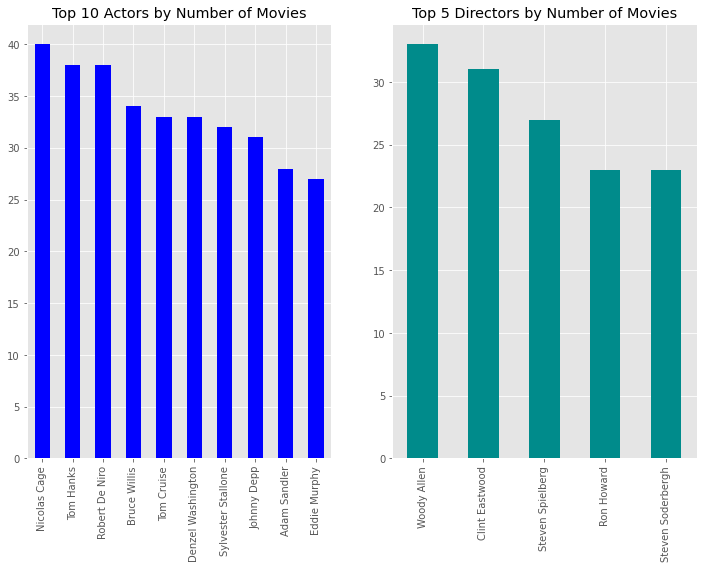

In [10]:
#2 

star = df.star.value_counts().head(10)
direc = df.director.value_counts().head(5)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
star.plot(kind='bar', ax=ax1, color='b', title='Top 10 Actors by Number of Movies');
direc.plot(kind='bar', ax=ax2, color='darkcyan', title='Top 5 Directors by Number of Movies');

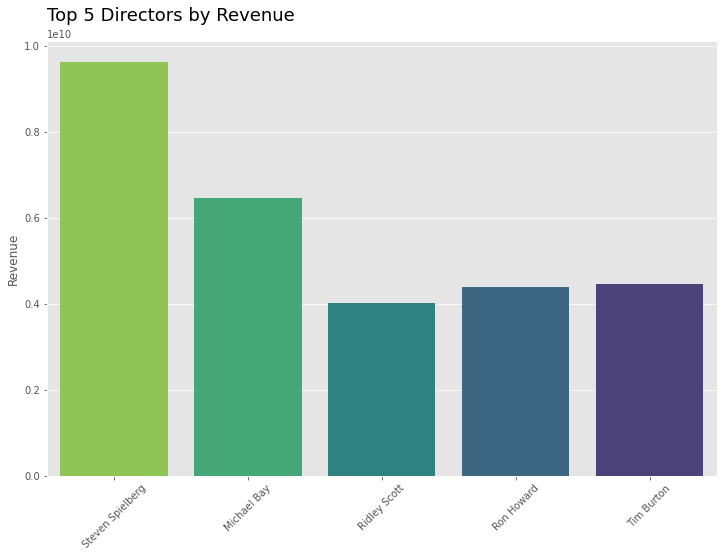

In [11]:
#3

direc_rev = df.groupby('director').sum().sort_values(by='budget', ascending=False).head(5)
sns.barplot(x=direc_rev.index, y='gross', data=direc_rev, palette='viridis_r');
plt.xticks(rotation=45);
plt.xlabel('');
plt.ylabel('Revenue');
plt.title('Top 5 Directors by Revenue', loc='left', fontsize=18, pad=20);

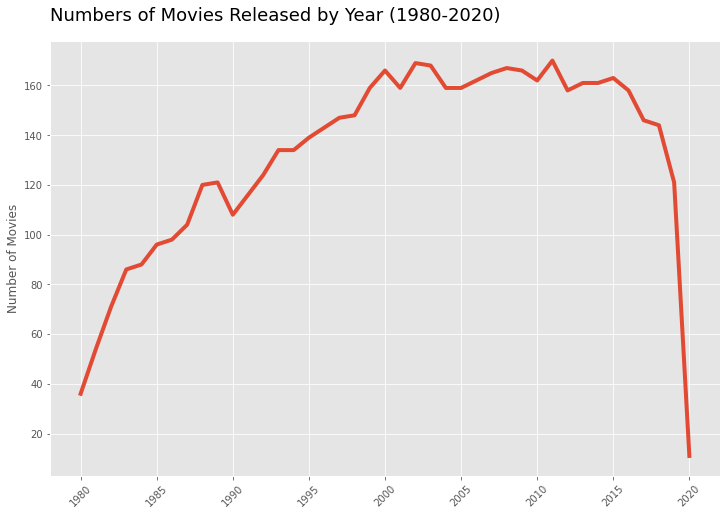

In [12]:
#4 

release_year = df.groupby('year').count()
sns.lineplot(x=release_year.index, y='name', data=release_year, linewidth=4);
plt.xticks(rotation=45);
plt.xlabel('');
plt.ylabel('Number of Movies');
plt.title('Numbers of Movies Released by Year (1980-2020)', loc='left', fontsize=18, pad=20);

##### A quick side note:
In 2020, we obviously had the surge of the Covid-19 pandemic, which clearly impacted the movie industry, as the previous graph denotes. Let's briefly see its impact on revenue:

In [13]:
year_rev = df.groupby('year').sum()['gross']
year_rev_pct = year_rev.pct_change()

rev_df = pd.DataFrame({
    'Yearly Revenue': year_rev, 
    'Yearly Revenue (%)': year_rev_pct * 100
    })

rev_df.iloc[-10:]

,Yearly Revenue,Yearly Revenue (%)
year,,
2011,23527825436,7.148040
2012,25412067550,8.008569
2013,25666428951,1.000947
2014,24852833034,-3.169884
2015,27305403552,9.868374
2016,27036473906,-0.984895
2017,28750488079,6.339637
2018,28009036751,-2.578917
2019,27442787346,-2.021667


It is clear that throughout the last decade, the revenue, in average, was notably stable, even with a few peaks (e.g. 2015, year in which we had **Star Wars VII, Jurassic World, Avengers: Age of Ultron, etc**). But in 2020, which cinemas and studios shut down, the industry's revenue fell by ~**89%**.

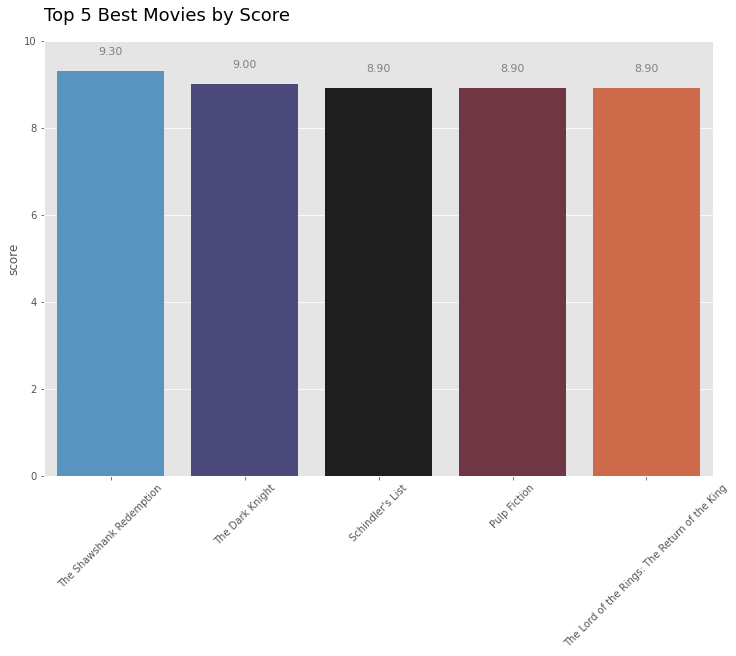

In [14]:
#5
best_movies = df.sort_values(by='score', ascending=False).head(5)
g = sns.barplot(x='name', y='score', data=best_movies, palette='icefire');
ax = g
plt.xticks(rotation=45);
plt.xlabel('');
plt.title('Top 5 Best Movies by Score', loc='left', fontsize=18, pad=20);

# displaying the scores:

for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                textcoords='offset points')
_ = g.set_ylim(0,10) 

# Correlation Analysis

##### The idea is to identify and investigate the features that are most highly correlated to **gross revenue**. 

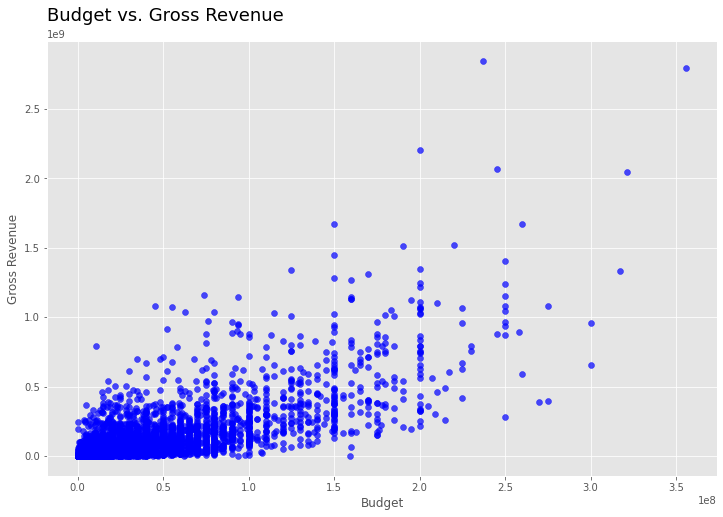

In [15]:
plt.scatter(x=df.budget, y=df.gross, color='b', alpha=.7);
plt.title('Budget vs. Gross Revenue', loc='left', fontsize=18, pad=20);
plt.xlabel('Budget');
plt.ylabel('Gross Revenue');

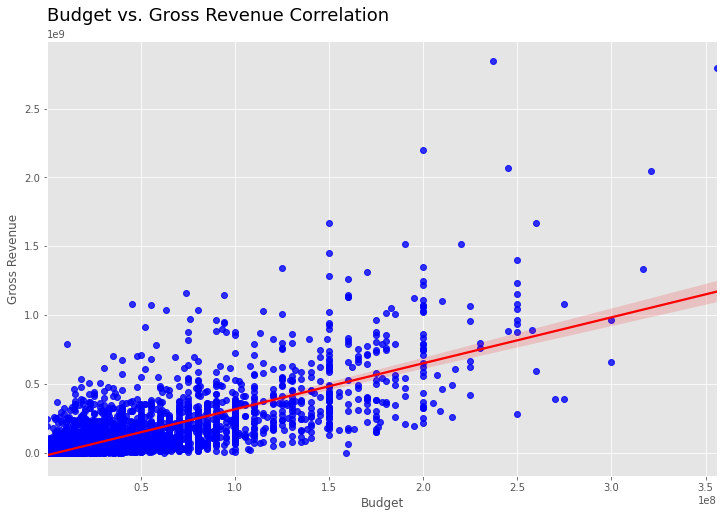

In [16]:
# regplot for a linear reg line

sns.regplot(data=df, x='budget', y='gross', color='b', line_kws={'color':'r'});
plt.title('Budget vs. Gross Revenue Correlation', loc='left', fontsize=18, pad=20);
plt.xlabel('Budget');
plt.ylabel('Gross Revenue');

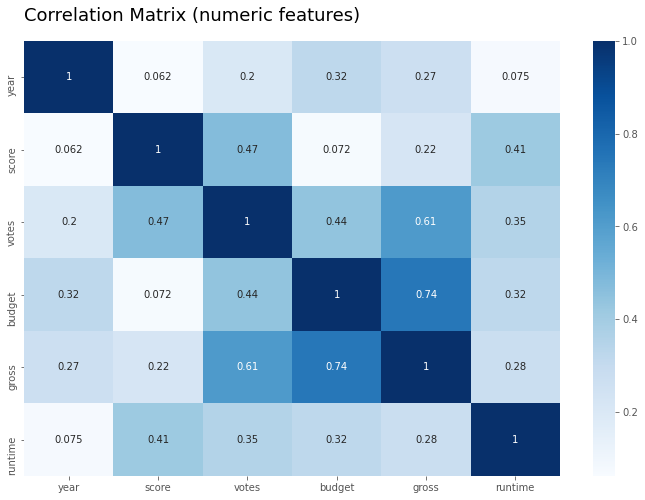

In [17]:
sns.heatmap(df.corr(method='pearson'), annot=True, cmap='Blues');
plt.title('Correlation Matrix (numeric features)', loc='left', fontsize=18, pad=20);

##### Dealing with the categorical variables
The following simply transforms each variable of the 'object' type to 'category', so they can be used for correlation analysis.

In [18]:
df_num = df.copy()

for col in df_num.columns:
    if (df_num[col].dtype == 'object'):
        df_num[col] = df_num[col].astype('category')
        df_num[col] = df_num[col].cat.codes

df_num.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,released_date,released_country
0,4692,5,6,1980,8.4,927000,1795,2832,699,46,19000000,46998772,1426,146.0,1980-06-13,47
1,3929,5,1,1980,5.8,65000,1578,1158,214,47,4500000,58853106,452,104.0,1980-07-02,47
2,3641,3,0,1980,8.7,1200000,757,1818,1157,47,18000000,538375067,945,124.0,1980-06-20,47
3,204,3,4,1980,7.7,221000,889,1413,1474,47,3500000,83453539,1108,88.0,1980-07-02,47
4,732,5,4,1980,7.3,108000,719,351,271,47,6000000,39846344,1083,98.0,1980-07-25,47


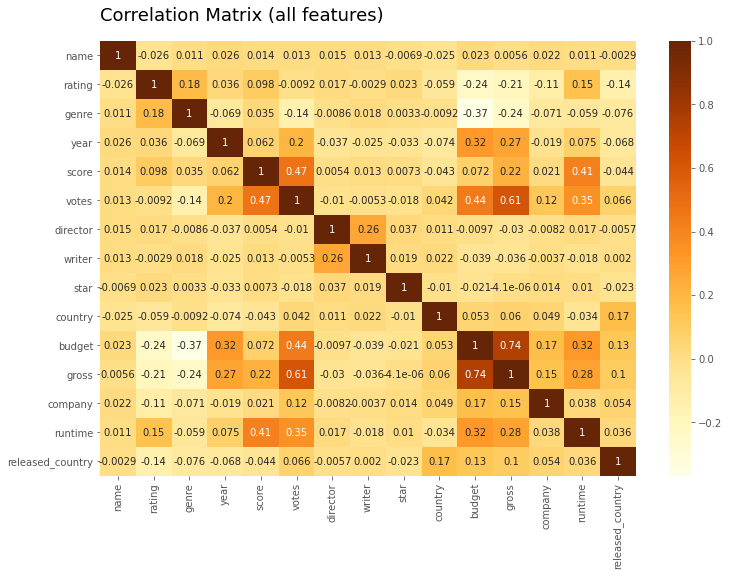

In [19]:
sns.heatmap(df_num.corr(method='pearson'), annot=True, cmap='YlOrBr');
plt.title('Correlation Matrix (all features)', loc='left', fontsize=18, pad=20);

##### Checking for high correlation

In [20]:
corr_mat = df_num.corr().unstack().sort_values(ascending=False)
corr_mat[((corr_mat) > .3) & ((corr_mat) != 1)]

budget   gross      0.740247
gross    budget     0.740247
         votes      0.614751
votes    gross      0.614751
         score      0.474256
score    votes      0.474256
votes    budget     0.439675
budget   votes      0.439675
runtime  score      0.414068
score    runtime    0.414068
votes    runtime    0.352303
runtime  votes      0.352303
year     budget     0.320312
budget   year       0.320312
runtime  budget     0.318695
budget   runtime    0.318695
dtype: float64

# Insights

Through this analysis, we can clearly see that variables like `company`, `director`, `star`, and `country` where a movie is released have little to no correlation with the actual revenue. Whereas `budget` and the `votes` a movie gets seems to have greater impact in its earnings.

Another interesting point is that the `year` of release tends to influentiate its `budget`. It is obvious that the movie industry has only gotten bigger year after year, so it is only natural that the average budget increases and, with that, the revenue. `Runtime` also shows some correlation with the `budget`, as longer films tend to cost higher to be produced.

That does not necessarily reflect the movie industry in its entirely, but surely allows for a deeper look into what tends to drive up revenues in the industry - and what does not.
<br>
---

# Regression Analysis

The goal of this section is to build a model that, given certain features (independent variables), could **predict the gross revenue** of a movie (dependent variable). For that, I will:
##### 1) Select the features to be used in the model
##### 2) Split between training and test sets 
##### 3) Scale numerical variables
##### 4) Evaluate the model and predict on test and sample data

In [21]:
# 1) The features I am going to use are those that have shown some correlation to the gross revenue, either negative or positive

feat = pd.DataFrame(df.corr().gross[(abs(df_num.corr().gross)) > .18].sort_values(ascending=False))
feat.iloc[1:] # excludes the 'gross', which is corr to itself

,gross
budget,0.740247
votes,0.614751
runtime,0.275796
year,0.268721
score,0.222556


In [22]:
# 2) Split the dataset

X = df[['budget', 'votes', 'runtime', 'year', 'score']]
y = df.gross

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [23]:
# 3) Scale the independent variables

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# 4) Build the model and draw predictions

linreg = LinearRegression()
linreg.fit(X_train, y_train)
predictions = linreg.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rsqrt = r2_score(y_test, predictions) * 100

print('MAE: {} \nMSE: {} \nRMSE: {} \nR-squared: {}'.format(mae, mse, rmse, rsqrt))

MAE: 59084361.03430919 
MSE: 1.1744164245626882e+16 
RMSE: 108370495.272592 
R-squared: 67.42279283030585


#### With only these features, the model can already explain roughly **67%** of the variability of the data.

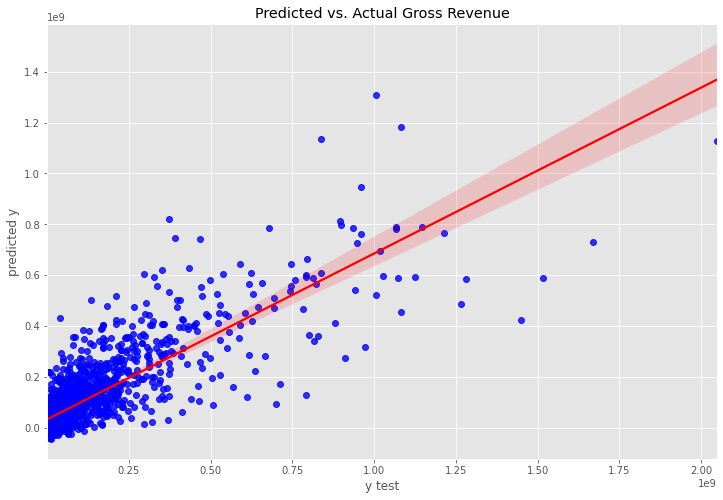

In [25]:
ax = sns.regplot(x=y_test, y=linreg.predict(X_test),
                scatter_kws={'color': 'blue'}, line_kws={'color':'red'});
ax.set(xlabel='y test', ylabel='predicted y');
ax.set(title='Predicted vs. Actual Gross Revenue');

In [26]:
coeff = pd.DataFrame(index=X.columns, columns=['Coefficients'], data=linreg.coef_)
coeff

,Coefficients
budget,1.104935e+08
votes,6.404252e+07
runtime,-9.970176e+06
year,2.749868e+06
score,6.403925e+06


## Thank you!
#### I truly appreciate you reading this far. Feel free to check out some of my Kaggle projects [here](https://www.kaggle.com/yanscosta/code).